<a href="https://colab.research.google.com/github/riteshcanfly/Python-AI-book/blob/master/Modeling_and_Prediction_in_Pytorch-california.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pytorch is by default in Colab
import the other important libraries

In [0]:
import torch
import numpy as np
import seaborn as sns
import urllib
import pandas as pd
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
RECIPE_ID = "RECIPE-4"


import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

Aim is to predict median house values in Californian districts, given a number of features from these districts.
Download the data as in the previous recipe and perform some preprocessing following these steps
* Looking at the big picture

* Data collection 

* Data visualization 

* Data discovery in order to gain insights 

* Data preparation for Machine Learning algorithms 

* Model selection and training 

* Fine-tuning the model

* Solution representation

* Launch, monitor, and maintain your system



In [0]:
def download_data(url, filename='housing.csv'):
  try:
    urllib.request.urlretrieve(url, filename=filename)
    print('file downloaded--- ')
  except:
    print('can not open the url %s' %(url))
    return None
   
url = 'https://github.com/riteshcanfly/Python-AI-book/raw/master/datasets/housing/housing.csv'
download_data(url=url)

file downloaded--- 


In [0]:
def read_data(filename='housing.csv'):
  try:
    data = pd.read_csv(filename)
  except:
    print('data read error no file named %s' %(filename))
    return None
  return data


filename = 'housing.csv'
train = read_data(filename=filename)
train.head()          

longitude  latitude  ...  median_house_value  ocean_proximity
0    -122.23     37.88  ...            452600.0         NEAR BAY
1    -122.22     37.86  ...            358500.0         NEAR BAY
2    -122.24     37.85  ...            352100.0         NEAR BAY
3    -122.25     37.85  ...            341300.0         NEAR BAY
4    -122.25     37.85  ...            342200.0         NEAR BAY

[5 rows x 10 columns]

In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Some descriptive statistics could be useful
mean, std, percentile etc.

In [0]:
train.describe()

longitude      latitude  ...  median_income  median_house_value
count  20640.000000  20640.000000  ...   20640.000000        20640.000000
mean    -119.569704     35.631861  ...       3.870671       206855.816909
std        2.003532      2.135952  ...       1.899822       115395.615874
min     -124.350000     32.540000  ...       0.499900        14999.000000
25%     -121.800000     33.930000  ...       2.563400       119600.000000
50%     -118.490000     34.260000  ...       3.534800       179700.000000
75%     -118.010000     37.710000  ...       4.743250       264725.000000
max     -114.310000     41.950000  ...      15.000100       500001.000000

[8 rows x 9 columns]

Understand the data a bit plot histograms to observe

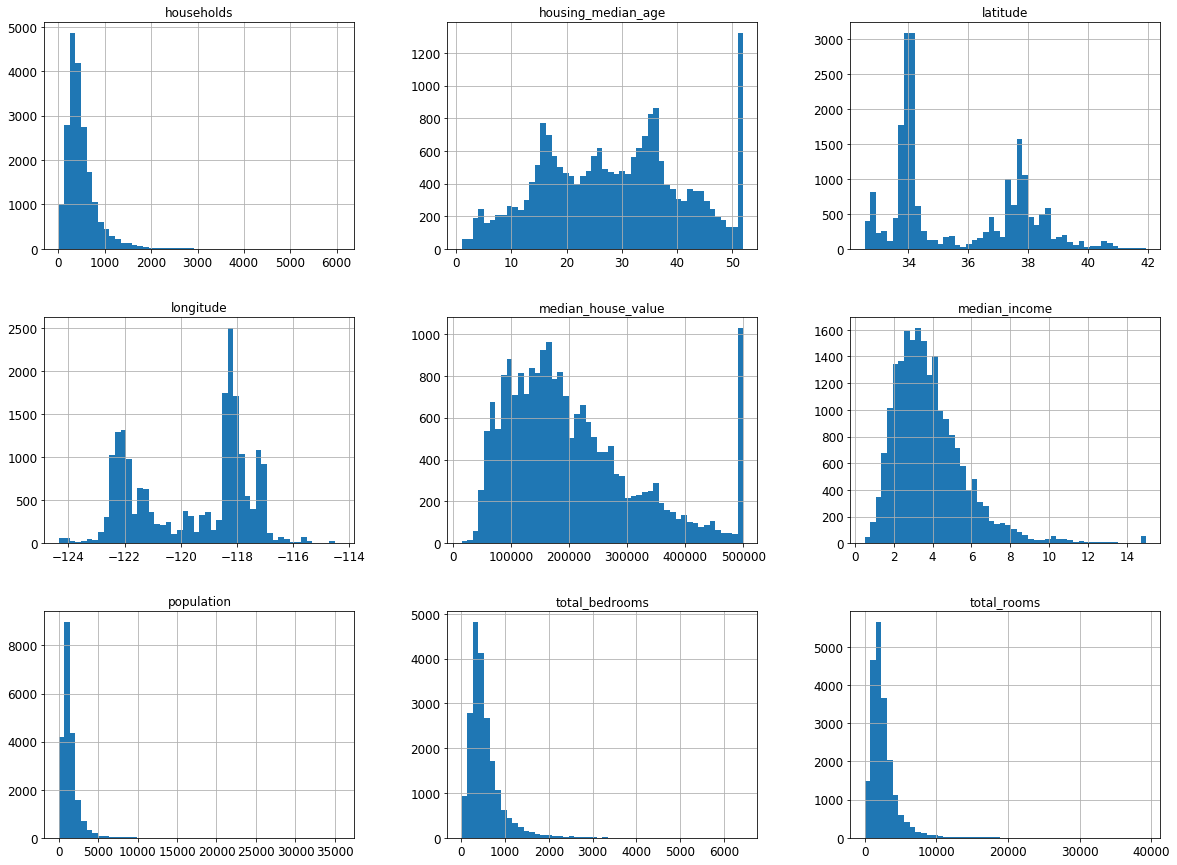

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
train.hist(bins=50, figsize=(20,15))
plt.show()


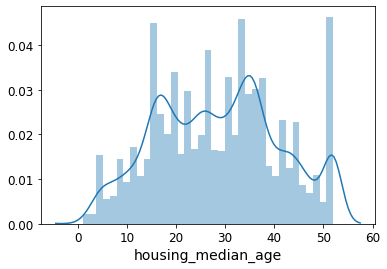

In [0]:
sns.distplot(train['housing_median_age'])

Some observations
* median income attribute : capped  1-15
* Median house value, median house age are also capped
* All attributes have different scales
* It could be a problem for Model development
* Histograms are tail heavy, need to have more bell-shaped distribution  


In [0]:
np.random.seed(12)
# train test splits could be done 
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(train, test_size=0.2, random_state=12)


In [0]:
train_set.head()

longitude  latitude  ...  median_house_value  ocean_proximity
1652     -121.97     37.93  ...            307000.0           INLAND
14652    -117.15     32.80  ...            166700.0       NEAR OCEAN
3548     -118.61     34.25  ...            276600.0        <1H OCEAN
6730     -118.14     34.11  ...            500001.0        <1H OCEAN
18445    -121.81     37.25  ...            251800.0        <1H OCEAN

[5 rows x 10 columns]

In the train and test splits, the data should have propotional representation of all the groups e.g. in this dataset the median income group can not be represented proportionately if a random split is performed. So, we perfrom a stratified split of the data 

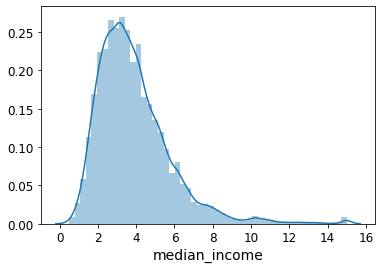

In [0]:
sns.distplot(train['median_income'])

The median income can be divided into some categories, i.e. we have people earning different levels of incomes. A simple cut across the incomes will confirm this.

In [0]:
# Dividing the income into categories and counting them
train["income_cat"] = pd.cut(train["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
train["income_cat"].value_counts()


3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

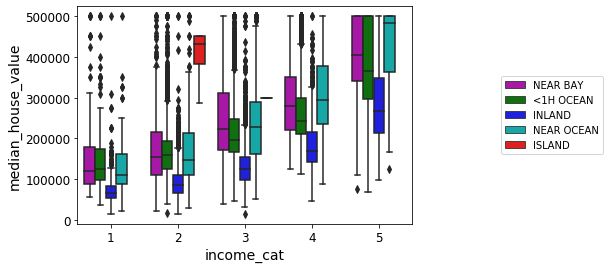

In [0]:
# some more visualization to understand the data
#sns.set(style="ticks", palette="pastel")

g  = sns.boxplot(x="income_cat", y = "median_house_value",
            hue ="ocean_proximity", palette=["m", "g", "b", "c", "r"],
            data = train)
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)


The box plots suggest: 
* The people in higher income category tend to buy higher priced houses wherever they stay, i.e. Near Bay or INLAND or Near Ocean. 
* The variance in the house prices in higher income category is also very high.
* The people in income_category 2 i.e. between 1.5 and 4 have bought houses on islands and are highly priced.
* The houses INLAND tend to be cheaper within the same income category.

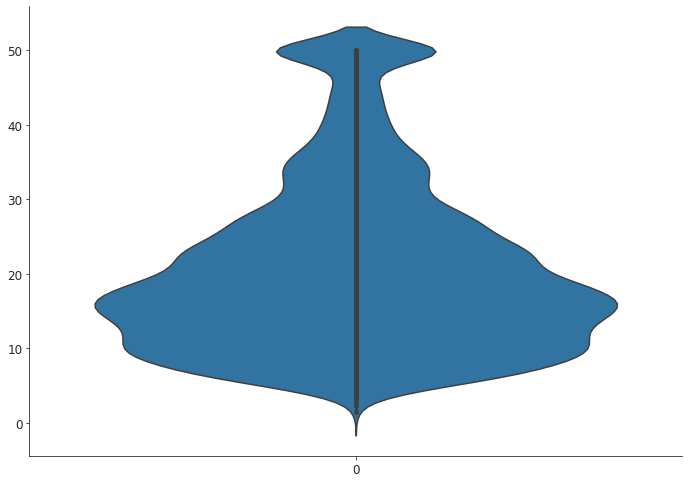

In [0]:
violin_attribs = train.columns[:-2]

sns.set_style('ticks')
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)
sns.violinplot(data = train['median_house_value']/10000, inner="points", ax=ax)    
sns.despine()

It hints at the proposition that the higher income category the higher the house_prices.



In [0]:
# perform stratified split on median_income
def stratified_split(data, n_splits = 1, test_size = 0.2, random_state = 12, column = ""):
  from sklearn.model_selection import StratifiedShuffleSplit
  split = StratifiedShuffleSplit(n_splits= n_splits, test_size=test_size, random_state=random_state)
  for train_index, test_index in split.split(data, data[column]):
      strat_train_set = data.loc[train_index]
      strat_test_set = data.loc[test_index]
  return strat_train_set, strat_test_set

n_splits  = 1
test_size = 0.2
random_state = 12
column = ""
strat_train_set, strat_test_set = stratified_split(train, n_splits = n_splits, test_size = test_size, 
                 random_state = random_state, column ="income_cat" )


Visualisation of data
* Make Sure to keep the test set aside
* Visualize the subset of training set if it is too large

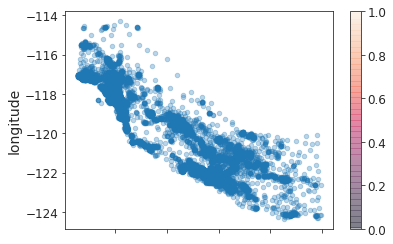

In [0]:
train.plot(kind="scatter", x="latitude", y="longitude", alpha=0.3,
           cmap = plt.get_cmap("cool"), colorbar = True ) # alpha is the transparency factor
# This can be performed using seaborne plot too

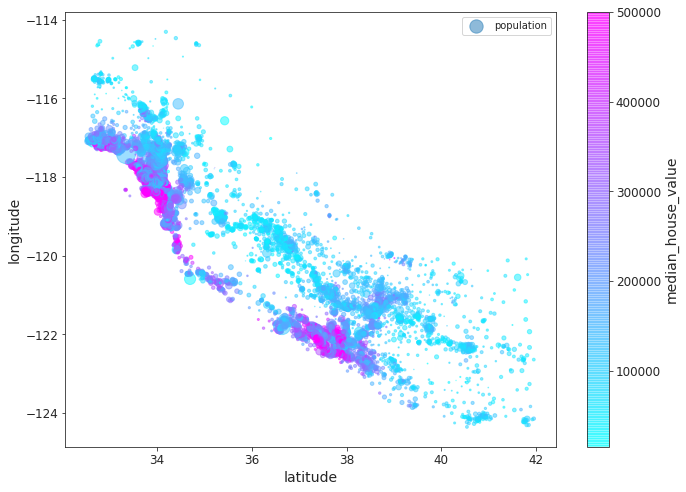

In [0]:
def plot_figure(data):
  data.plot(
      kind="scatter", x="latitude", y="longitude", alpha=0.5,
      label="population", s = data["population"] / 100, figsize=(11, 8),
      c="median_house_value",colorbar=True,
      sharex = False, cmap = plt.get_cmap("cool")
  )
  plt.legend()
plot_figure(train)

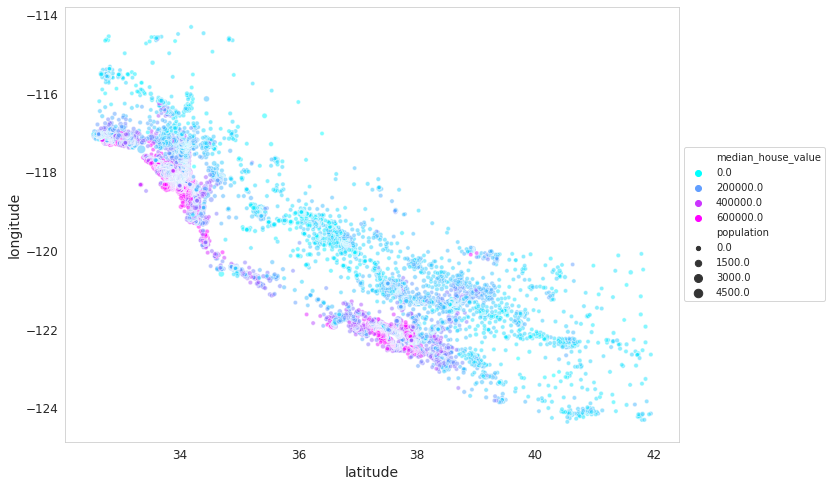

In [0]:
sns.set_style("whitegrid", {'axes.grid' : False})
f, ax = plt.subplots(figsize=(11, 8))
cmap = sns.cubehelix_palette(dark=.3, light=1, as_cmap=True)
g = sns.scatterplot(x="latitude", y ="longitude",
                hue = "median_house_value",size = train['population']/10, 
                alpha = 0.5, palette = plt.get_cmap("cool"),
                data = train, ax = ax)

g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

Clearly in this data the proximity to ocean plays a role in determining the median_house values, atleast we can farely say that the closer the houses are to the ocean the higher price they have. 
The population density is also towards higher side to the ocean(s aprameter in the function) 

Look for Correlations:
Why is it needed?
* To understand related features
* To gather better insights


In [0]:
corr = train.corr()
# correlation with house values
corr['median_house_value'].sort_values()

latitude             -0.144160
longitude            -0.045967
population           -0.024650
total_bedrooms        0.049686
households            0.065843
housing_median_age    0.105623
total_rooms           0.134153
median_income         0.688075
median_house_value    1.000000
Name: median_house_value, dtype: float64

In [0]:
train.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'income_cat'],
      dtype='object')

Clearly the house value depends on the income which is obvious as richer people will buy costlier houses and interestingly it also decreases as latitude increases.

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


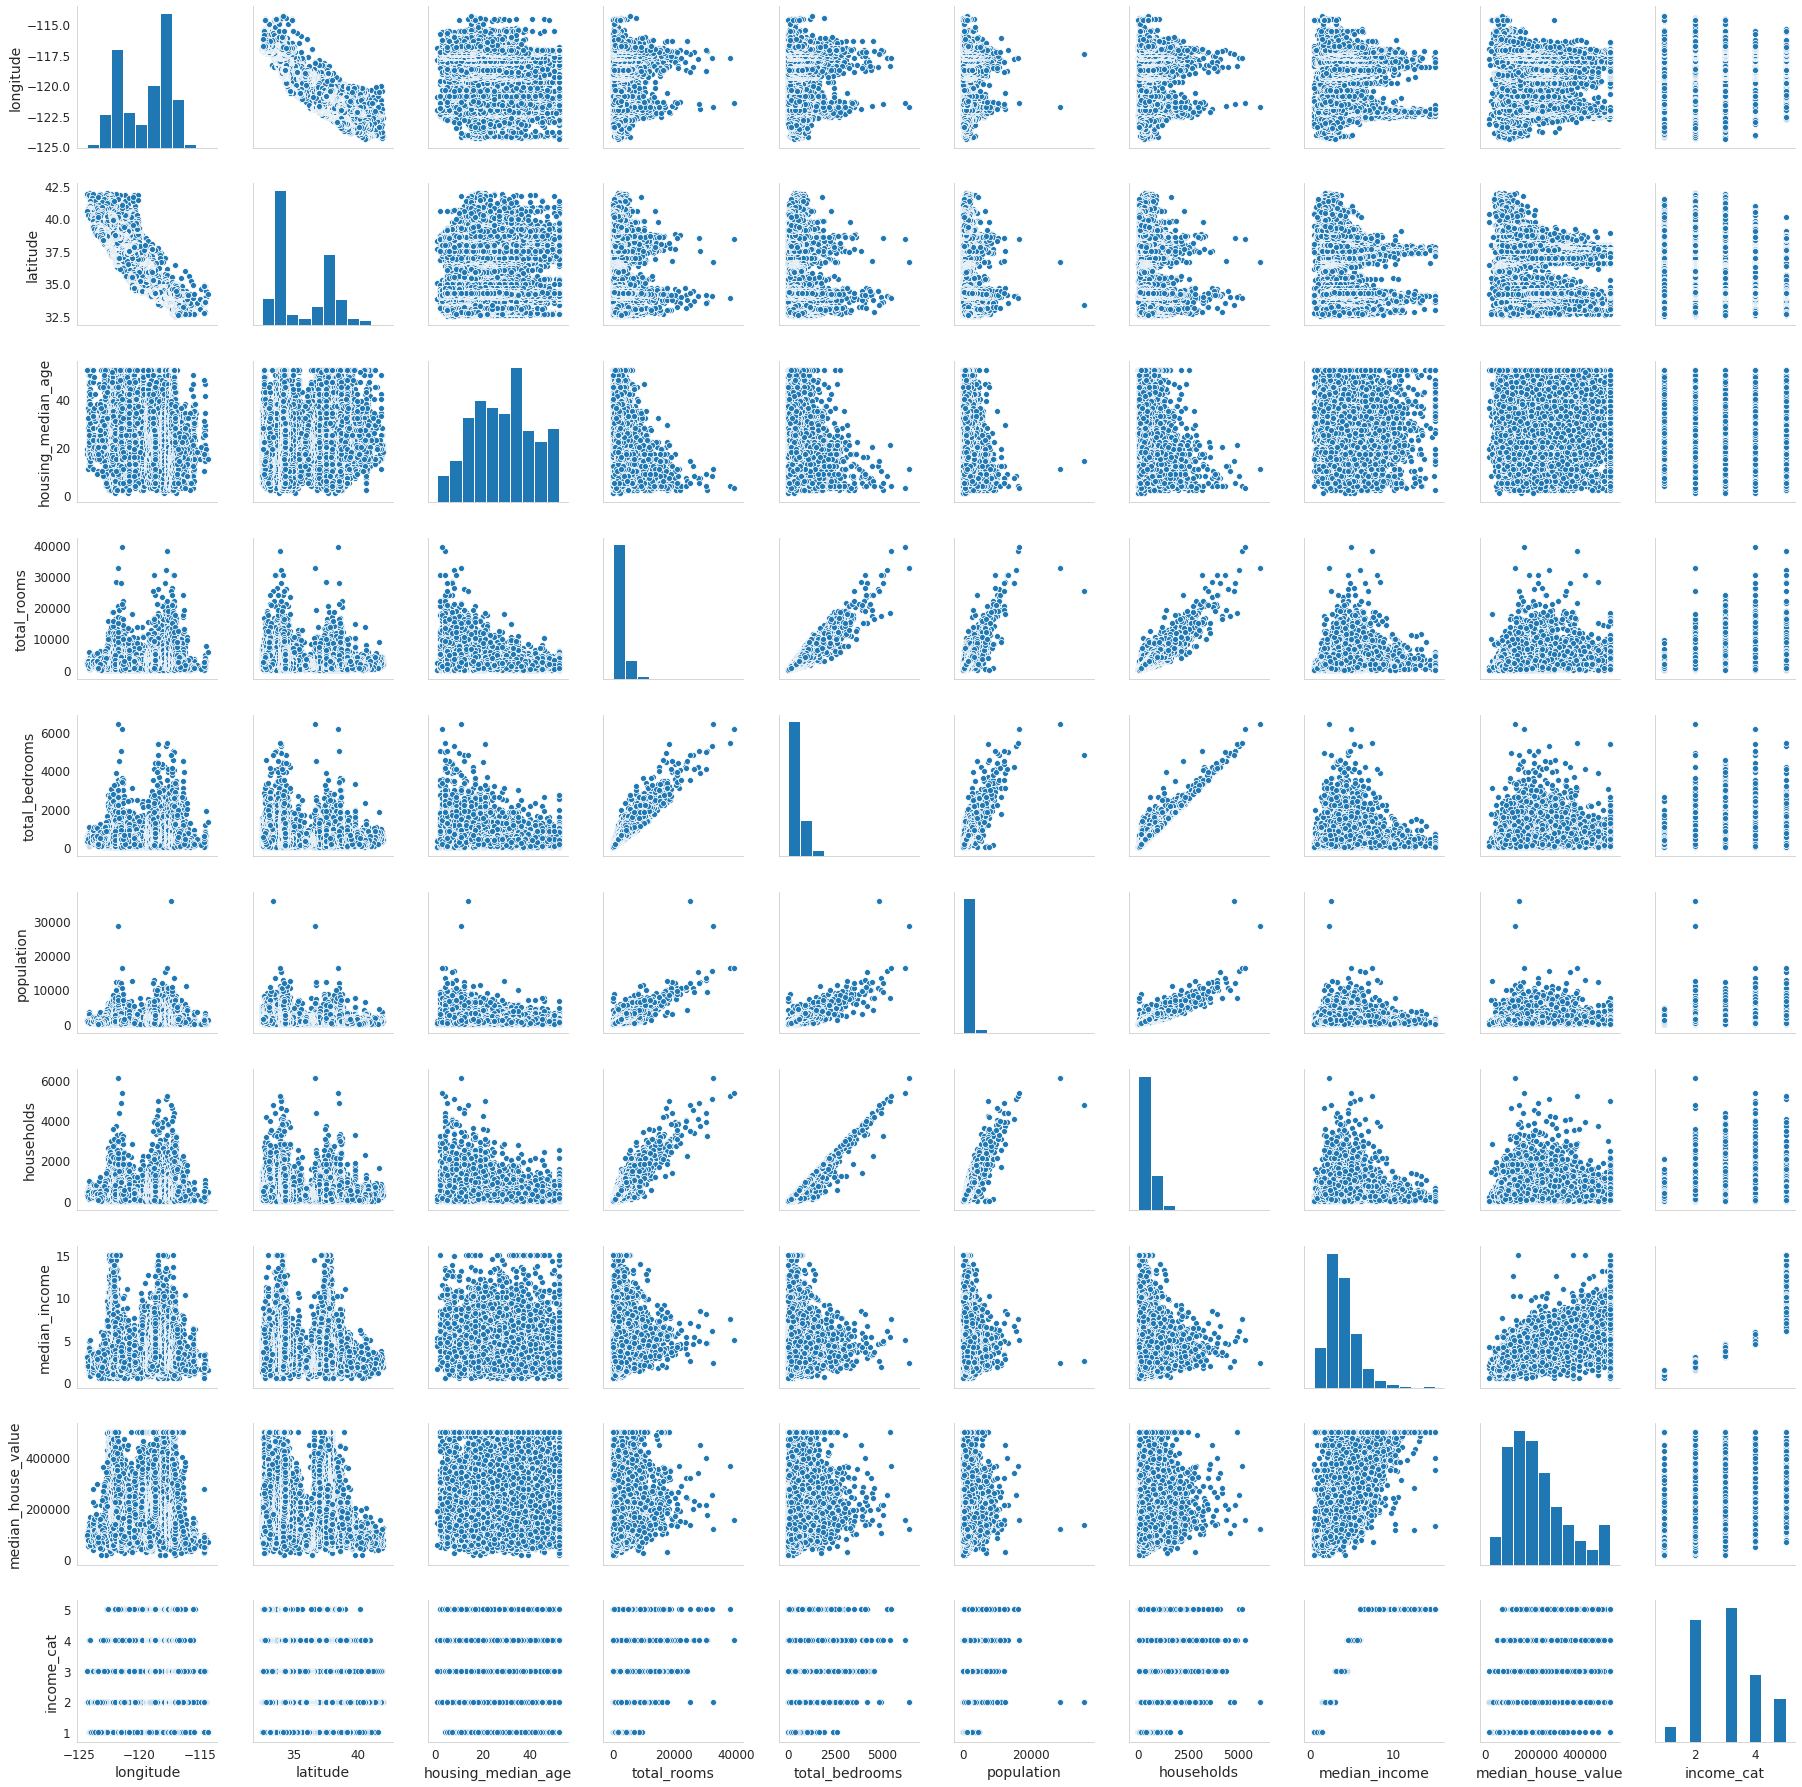

In [0]:
# pairplot

g = sns.pairplot(train,  palette='husl' )


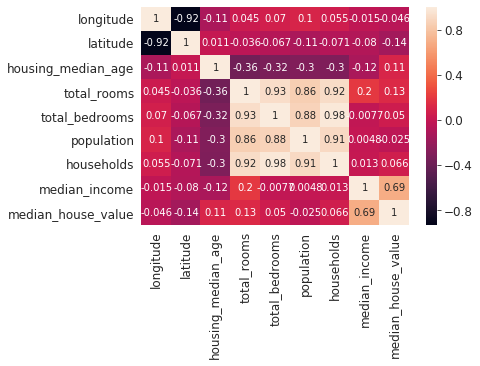

In [0]:
sns.heatmap(data=corr, annot=True)


The correlation plot shows some interesting and some obvious things
* The house value and income of the persons are highly correlated.
* The bigger the household is the larger the number of bedrooms, total rooms etc.
* The younger people tend to live in smaller house, there is a negative correltion between the median_age and total rooms in a house bought.
* Also younger people generally have lower income, but the there is an overall positive correaltion between the house price and age of the household.

**Feature Engineering**

Perform some feature engineering if known or established, e.g. here we could add rooms_per_house, bedrooms_per_house, size_household to the data to augment the features. 

In [0]:
train["household_size"]= train["population"]/train["households"]
train["rooms_per_house"] = train["total_rooms"]/train["households"]
train["bedrooms_per_house"] = train["total_bedrooms"]/train["total_rooms"]
# get new correlation values to check

# Prepare the data for Machine Learning algorithms

* Data cleaning
    * Separate predictors and the label
    * Missing values
        * Get rid of the corresponding values.
        * Get rid of the whole attribute.
        * Set the values to some value (zero, the mean, the median, etc.).
            * If imputation is chosen, the median or other statistic should be computed on the training set as it will be used to fill the missing values in the training set, it should be saved. This will be needed later to replace missing values in the test set when the system evaluation is to be done and also once the system goes live to replace missing values in new data.

In [0]:
train = strat_train_set.drop("median_house_value", axis=1)  # drop labels for training set
train_labels = strat_train_set["median_house_value"].copy()

In [0]:
NA_rows = train[train.isnull().any(axis=1)].head()
NA_rows

longitude  latitude  ...  ocean_proximity  income_cat
18346    -122.15     37.43  ...         NEAR BAY           2
13332    -117.65     34.04  ...           INLAND           3
7316     -118.19     33.98  ...        <1H OCEAN           2
2301     -119.78     36.82  ...           INLAND           3
11741    -121.13     38.87  ...           INLAND           3

[5 rows x 10 columns]

Here imputation is chosen. An imputation instance of the scikit learn is created which can be used further downstream during model creation and evaluation.

In [0]:

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
# This imputation can however be only done on numerical attributes 
# so the other attributes have to be separately handled

In [0]:
train_numericals = train.select_dtypes(include=[np.number])
imputer.fit(train_numericals)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [0]:
# Now perform the transformation
X = imputer.transform(train_numericals)
train_tr = pd.DataFrame(X, columns=train_numericals.columns,
                          index=train_numericals.index)
train_tr.head()

longitude  latitude  ...  households  median_income
13643    -117.33     34.06  ...       139.0         2.5673
11573    -118.00     33.77  ...       264.0         3.4327
20322    -119.14     34.23  ...        80.0         2.5714
16484    -121.06     38.25  ...       104.0         3.6528
12136    -117.13     33.89  ...        84.0         3.5781

[5 rows x 8 columns]

In [0]:
# Perform One-Hot encoding of categorical values
train_cat = train[['ocean_proximity']]
train_cat.head(10)

ocean_proximity
13643          INLAND
11573       <1H OCEAN
20322      NEAR OCEAN
16484          INLAND
12136          INLAND
6388           INLAND
11197       <1H OCEAN
20206      NEAR OCEAN
1657           INLAND
10829       <1H OCEAN

In [0]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder(sparse=False)
train_cat_1hot = cat_encoder.fit_transform(train_cat)
train_cat_1hot

array([[0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

All of this can be transformed into a pipeline, scikit provides a pipeline mechanism. So the pipeline will have following workflow
* Add features
* Imputation of numerical attributes
* Normalization of the numerical attributes
* One hot encoding of categorical values

In [0]:
rooms_ix, bedrooms_ix, population_ix, household_ix = [
    list(train.columns).index(col)
    for col in ("total_rooms", "total_bedrooms", "population", "households")]

from sklearn.preprocessing import FunctionTransformer
def add_extra_features(X, add_bedrooms_per_house = False):
    rooms_per_house = X[:, rooms_ix] / X[:, household_ix]
    population_per_house = X[:, population_ix] / X[:, household_ix]
    if add_bedrooms_per_house:
        bedrooms_per_house = X[:, bedrooms_ix] / X[:, rooms_ix]
        return np.c_[X, rooms_per_house, population_per_house,
                     bedrooms_per_house]
    else:
        return np.c_[X, rooms_per_house, population_per_house]

attr_adder = FunctionTransformer(add_extra_features, validate = False,
                                 kw_args={"add_bedrooms_per_house": False})
train_extra_attribs = attr_adder.fit_transform(train.values)

In [0]:
train_extra_attribs = pd.DataFrame(
    train_extra_attribs,
    columns=list(train.columns)+["rooms_per_house", "population_per_house"],
    index=train.index)
train_extra_attribs.head()

longitude latitude  ... rooms_per_house population_per_house
13643   -117.33    34.06  ...         5.26619               3.4964
11573      -118    33.77  ...         5.01515              2.60227
20322   -119.14    34.23  ...          3.0375                1.275
16484   -121.06    38.25  ...         6.25962              2.89423
12136   -117.13    33.89  ...         19.1786              3.27381

[5 rows x 12 columns]

In [0]:
print(train_extra_attribs.shape)
print(train.shape)
print(train)
# remove income_cat for the time being
train = train.drop('income_cat', axis  = 1)


(16512, 12)
(16512, 10)
       longitude  latitude  ...  ocean_proximity  income_cat
13643    -117.33     34.06  ...           INLAND           2
11573    -118.00     33.77  ...        <1H OCEAN           3
20322    -119.14     34.23  ...       NEAR OCEAN           2
16484    -121.06     38.25  ...           INLAND           3
12136    -117.13     33.89  ...           INLAND           3
...          ...       ...  ...              ...         ...
10364    -117.68     33.61  ...        <1H OCEAN           5
18097    -122.05     37.33  ...        <1H OCEAN           5
6537     -118.03     34.06  ...        <1H OCEAN           2
2227     -119.77     36.86  ...           INLAND           5
10725    -117.82     33.64  ...        <1H OCEAN           5

[16512 rows x 10 columns]


In [0]:
train.head()

longitude  latitude  ...  median_income  ocean_proximity
13643    -117.33     34.06  ...         2.5673           INLAND
11573    -118.00     33.77  ...         3.4327        <1H OCEAN
20322    -119.14     34.23  ...         2.5714       NEAR OCEAN
16484    -121.06     38.25  ...         3.6528           INLAND
12136    -117.13     33.89  ...         3.5781           INLAND

[5 rows x 9 columns]

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

numerical_attribs = list(train_numericals)
categorical_attribs = ["ocean_proximity"]

numerical_pipeline = Pipeline(steps = [
        ('impute', SimpleImputer(strategy="median")),
        ('attrib', FunctionTransformer(add_extra_features, validate=False)),
        ('normalise', StandardScaler()),
    ])
categorical_pipeline = Pipeline(steps = [('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer([
        ("num_pipeline", numerical_pipeline, numerical_attribs),
        ("cat_pipeline", categorical_pipeline, categorical_attribs),
    ])
train_prepared = preprocessor.fit_transform(train) 

In [0]:
print(numerical_attribs)
print(categorical_attribs)
print(train.shape)
print(train_prepared)
print(train_prepared.shape)

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
['ocean_proximity']
(16512, 9)
[[ 1.12238154 -0.73916342  1.54019195 ...  0.          0.
   0.        ]
 [ 0.78812581 -0.87470615 -0.3699156  ...  0.          0.
   0.        ]
 [ 0.21939218 -0.65970734 -1.64332064 ...  0.          0.
   1.        ]
 ...
 [ 0.77315913 -0.73916342 -0.3699156  ...  0.          0.
   0.        ]
 [-0.09490798  0.56952498 -1.72290845 ...  0.          0.
   0.        ]
 [ 0.87792585 -0.93546668 -0.84744249 ...  0.          0.
   0.        ]]
(16512, 15)


Now perform machine learning. This is a regression problem in which the cost of the household is to be predicted based on the other attributes. 

## Hypothesis of Linear Regression
The linear regression model can be represented by the following equation

![thetas](https://github.com/riteshcanfly/Python-AI-book/raw/master/images/end_to_end_project/thetas.png)

This can also be represented by

![matform](https://github.com/riteshcanfly/Python-AI-book/raw/master/images/end_to_end_project/thetastr.png)

The model accuracy is defined by a cost function which can be sum squares of errors (predicted-actual). It can be denoted by

![cost](https://github.com/riteshcanfly/Python-AI-book/raw/master/images/end_to_end_project/costfun.png)

where the hypothesis function h(x) is defined by

![hypothesis](https://github.com/riteshcanfly/Python-AI-book/raw/master/images/end_to_end_project/hypothesis.png)

There can be other cost function like [cross-entropy, hinge loss](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html) etc. 
## Gradient descent

Gradient descent is the most popular optimization algorithm used in many machine learning algorithms. The algorithms minimizes the cost function by iteratively changing the value of theta (coefficients of the model) according to the gradient of the errors. It follows the following steps 

1. Intialization
  * The parameters (thetas) are initialized randomly or with predefined values if their potential values are known before hand.
2. Gradient of errors
  * Next, the grad of error or the cost function is found by taking the partial derivatives according to the parameters i.e. with θ₀, θ₁, … , θn

  ![d0](https://github.com/riteshcanfly/Python-AI-book/raw/master/images/end_to_end_project/derivatives0.png)

  ![d1](https://github.com/riteshcanfly/Python-AI-book/raw/master/images/end_to_end_project/derivatives.png)

  The partial derivatives for all parameters can be written in a matrix notation using
  
  ![alld](https://github.com/riteshcanfly/Python-AI-book/raw/master/images/end_to_end_project/allderivatives.png)


3. Update rule
  * The parameters can be updated using the following update rule

  ![allgrad](https://github.com/riteshcanfly/Python-AI-book/raw/master/images/end_to_end_project/allupdates.png)

4. Iteration
  * The gradient and update rule step is repeated iteratively till the cost achieves its minimum or the maximum number of iteration is reached. The value of α (learning rate) determines the rate of convergence of the algorithm. 

The deep learning neural network frameworks use different optimization algorithms popular among them are 
**Stochastic Gradient Descent** (SGD), **RMSProp** (RPROP) and **ADAM**.

SGD works same as gradient descent except that it works on a single example at a time. The interesting part is that the convergence is similar to the gradient descent and is easier on the computer memory.

RMSPROP works by adapting the learning rates of the algorithm according to the gradient signs. The simplest of the variants checks the last two gradient signs if they are same then adapts the learning rate by increasing it by a fraction, if they are different then decreases it by a fraction. 

ADAM is an adaptive learning algorithm which changes the learning rate according to the first and second moments of the gradients. It is in a way mixture of SGD and RMSPROP.   

Detailed discussion on these algorithms can be found at
* https://imaddabbura.github.io/post/gradient-descent-algorithm/
* [Stochastic Estimation of the Maximum of a Regression Function ](https://projecteuclid.org/euclid.aoms/1177729392)
* https://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf
* [Adam: A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980)


In [0]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(train_prepared, train_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
from sklearn.metrics import mean_squared_error

train_predictions = lin_reg.predict(train_prepared)
linear_mse = mean_squared_error(train_labels, train_predictions)
linear_rmse = np.sqrt(linear_mse)
linear_rmse

68278.4631173995

Randomforest Regressor

In [0]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=10, random_state=12)
rf_reg.fit(train_prepared, train_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=12, verbose=0,
                      warm_start=False)

In [0]:
print('Random Forest MSError', np.mean((rf_reg.predict(train_prepared) - train_predictions) ** 2))


Random Forest MSError 3323151121.147824


DecisionTree Regressor

In [0]:
from sklearn.tree import DecisionTreeRegressor

dectree_reg = DecisionTreeRegressor(random_state = 12)
dectree_reg.fit(train_prepared, train_predictions)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=12, splitter='best')

In [0]:
train_predictions = dectree_reg.predict(train_prepared)
dectree_mse = mean_squared_error(train_labels, train_predictions)
dectree_rmse = np.sqrt(dectree_mse)
dectree_rmse

68278.4631173995

SVR (Support Vector Regression)

In [0]:
from sklearn.svm import SVR

svr_reg = SVR(kernel="linear")
svr_reg.fit(train_prepared, train_labels)
train_predictions = svr_reg.predict(train_prepared)
svr_mse = mean_squared_error(train_labels, train_predictions)
svr_rmse = np.sqrt(svr_mse)
svr_rmse

111112.70340346324

The models here need fine-tuning i.e. these estimates have to be finetuned. 

Crossvalidation and Model Selection



In [0]:
def descriptive_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [0]:
from sklearn.model_selection import cross_val_score
rf_scores = cross_val_score(rf_reg, train_prepared, train_labels,
                         scoring="neg_mean_squared_error", cv=10)
rf_rmse_scores = np.sqrt(-rf_scores)
descriptive_scores(rf_rmse_scores)

Scores: [55467.04219832 53844.05857041 52883.89178109 53543.46788128
 53741.79017129 54903.26611139 52056.63900757 51241.15055634
 54323.14579288 47814.90263769]
Mean: 52981.93547082584
Standard deviation: 2095.14707324367


In [0]:
lin_scores = cross_val_score(lin_reg, train_prepared, train_labels, 
                             scoring = "neg_mean_squared_error", cv =10)
lin_rmse_scores = np.sqrt(-lin_scores)
descriptive_scores(lin_rmse_scores)

Scores: [72205.18413406 68828.35552613 64809.80894217 68669.56847453
 67359.89867861 69241.05922349 69220.37894316 67762.23531286
 72694.04351363 63522.17039429]
Mean: 68431.27031429022
Standard deviation: 2696.5953267308073


In [0]:
dectree_scores = cross_val_score(dectree_reg, train_prepared, train_labels, 
                             scoring = "neg_mean_squared_error", cv =10)
dectree_rmse_scores = np.sqrt(-dectree_scores)
descriptive_scores(dectree_rmse_scores)

Scores: [71795.89066169 73352.47852898 70275.52044369 72445.99342586
 71049.80553232 70826.53949757 71832.9299663  68792.17454167
 69826.79111494 64368.2382074 ]
Mean: 70456.63619204162
Standard deviation: 2383.032538464439


In [0]:
rf_scores = cross_val_score(rf_reg, train_prepared, train_labels,
                                scoring ="neg_mean_squared_error", cv=10)
rf_rmse_scores = np.sqrt(-rf_scores)
descriptive_scores(rf_rmse_scores)

Scores: [55467.04219832 53844.05857041 52883.89178109 53543.46788128
 53741.79017129 54903.26611139 52056.63900757 51241.15055634
 54323.14579288 47814.90263769]
Mean: 52981.93547082584
Standard deviation: 2095.14707324367


parameter selection

GridSearch  

In [0]:
# search for the best parameters in a grid
# RandomForest parameters
## n_estimators: 4,20,30
## max_features: 3, 5, 10
## bootstrap:??

from sklearn.model_selection import GridSearchCV

param_grid = [
    # hyperparameters
    {'n_estimators': [4, 20, 30], 'max_features': [3, 5, 10]}
  ]

forest_reg = RandomForestRegressor(random_state = 12)
# train across 5 folds 
grid_search = GridSearchCV(forest_reg, param_grid, cv = 5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(train_prepared, train_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=12,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_features': [3, 5, 10],
    

In [0]:
print("best paramters:", grid_search.best_params_)
print("best estimators:",grid_search.best_estimator_)

best paramters: {'max_features': 5, 'n_estimators': 30}
best estimators: RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=5, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=12, verbose=0,
                      warm_start=False)


In [0]:
grid_search.cv_results_

{'mean_fit_time': array([0.10365787, 0.51586766, 0.79053402, 0.1583776 , 0.76938815,
        1.15783048, 0.2844975 , 1.44708161, 2.13245416]),
 'mean_score_time': array([0.00438771, 0.01961751, 0.02907848, 0.00488906, 0.02035851,
        0.02903628, 0.00470228, 0.02100539, 0.0293961 ]),
 'mean_test_score': array([-3.14442165e+09, -2.57454888e+09, -2.52302643e+09, -3.03463259e+09,
        -2.52291860e+09, -2.43160366e+09, -3.14000767e+09, -2.58194297e+09,
        -2.52794148e+09]),
 'mean_train_score': array([-7.93725129e+08, -4.28401912e+08, -3.96224709e+08, -7.47142585e+08,
        -4.17160193e+08, -3.78203825e+08, -7.48388407e+08, -4.20042642e+08,
        -3.89163795e+08]),
 'param_max_features': masked_array(data=[3, 3, 3, 5, 5, 5, 10, 10, 10],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[4, 20, 30, 4, 20, 30, 4, 20, 30],
          

explaining predictions

In [0]:
!pip install lime

     |████████████████████████████████| 276kB 5.1MB/s 
  Created wheel for lime: filename=lime-0.1.1.37-cp36-none-any.whl size=284277 sha256=4e1c7333b3b9f4bc8c032591d6aeb2594dc4c7f2ec4fe32c4f18fec02e133d14
  Stored in directory: /root/.cache/pip/wheels/c1/38/e7/50d75d4fb75afa604570dc42f20c5c5f5ab26d3fbe8d6ef27b
  Created wheel for progressbar: filename=progressbar-2.5-cp36-none-any.whl size=12073 sha256=0ea4083a7b62d40a043fc6d6f971f3e6b142a5959e6ab1de829a0708eec7f342
  Stored in directory: /root/.cache/pip/wheels/c0/e9/6b/ea01090205e285175842339aa3b491adeb4015206cda272ff0
Successfully built lime progressbar


In [0]:
import lime
import lime.lime_tabular

In [0]:
print(train.shape)
print(len(train_extra_attribs.columns))
new_features = ['rooms_per_house',	'population_per_house']
s  = preprocessor.named_transformers_['cat_pipeline']
#preprocessor
one_hotfeatures = list(s.named_steps['onehot'].categories_[0])
all_atttributenames = numerical_attribs + new_features + one_hotfeatures
all_atttributenames

(16512, 9)
12


['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'rooms_per_house',
 'population_per_house',
 '<1H OCEAN',
 'INLAND',
 'ISLAND',
 'NEAR BAY',
 'NEAR OCEAN']

In [0]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([0.09260656, 0.09236204, 0.04152549, 0.02161135, 0.0200261 ,
       0.02072561, 0.01881049, 0.34972402, 0.08035454, 0.10245236,
       0.01271609, 0.13740983, 0.00035101, 0.00380541, 0.0055191 ])

In [0]:
sorted(zip(feature_importances, all_atttributenames), reverse=True)

[(0.3497240244402743, 'median_income'),
 (0.13740982674344604, 'INLAND'),
 (0.10245236423484343, 'population_per_house'),
 (0.09260656160633322, 'longitude'),
 (0.09236204383939461, 'latitude'),
 (0.08035454167621321, 'rooms_per_house'),
 (0.04152548521522393, 'housing_median_age'),
 (0.021611345611708306, 'total_rooms'),
 (0.020725605420133957, 'population'),
 (0.02002609861278226, 'total_bedrooms'),
 (0.01881049046424965, 'households'),
 (0.012716085742565256, '<1H OCEAN'),
 (0.00551910296366767, 'NEAR OCEAN'),
 (0.00380540988740614, 'NEAR BAY'),
 (0.0003510135417579962, 'ISLAND')]

In [0]:
train_lm = pd.DataFrame(data = train_prepared,columns = all_atttributenames)
print(train_lm.isna().sum())
train_lm['house_median_price'] = train_labels.values
print(train_lm.isna().sum())

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms          0
population              0
households              0
median_income           0
rooms_per_house         0
population_per_house    0
<1H OCEAN               0
INLAND                  0
ISLAND                  0
NEAR BAY                0
NEAR OCEAN              0
dtype: int64
longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms          0
population              0
households              0
median_income           0
rooms_per_house         0
population_per_house    0
<1H OCEAN               0
INLAND                  0
ISLAND                  0
NEAR BAY                0
NEAR OCEAN              0
house_median_price      0
dtype: int64


In [0]:
 train_lm.head()
 #print(train_labels)


longitude  latitude  ...  NEAR OCEAN  house_median_price
0   1.122382 -0.739163  ...         0.0             68200.0
1   0.788126 -0.874706  ...         0.0            192800.0
2   0.219392 -0.659707  ...         1.0            500001.0
3  -0.738475  1.219195  ...         0.0            200000.0
4   1.222159 -0.818620  ...         0.0            244400.0

[5 rows x 16 columns]

**LIME**

Local Interpretable Model-Agnostic Explanations (LIME) is a very useful technique to identify an interpretable model in which the explainablity of the features can be quantified and trusted. 
The detalied mathematical explanation can be obtained from the original paper (https://arxiv.org/abs/1602.04938).
To summarise, this technique learns the behaviour of the model by perturbing the input and observing the predictions based on the model. 

This is important for building trust among the model huilders and the users. We have already downloaded and installed lime. The repo can be found at (https://github.com/marcotcr/lime). 

Here, a tabular explainer instance is created providing the features to be explained along with the original labels/values. The next step is to use the model developed and ask for the feature importances on a particular instance. 

In [0]:
explainer = lime.lime_tabular.LimeTabularExplainer(train_prepared,training_labels= train_labels.values,
                                                   feature_names = all_atttributenames, 
                                                   verbose=True,
                                                   mode='regression')


In [0]:
exp = explainer.explain_instance(train_prepared[10], grid_search.best_estimator_.predict,
                                 labels= train_labels.values[10],num_features=5)


Intercept 153847.0210095885
Prediction_local [339740.94184127]
Right: 243740.03333333333


In [0]:
exp.show_in_notebook(show_table=True)


**Explanation**

We asked for the explanation of top 5 features. The LIME explainer has presented a figure identifying 4 features i.e. median_income, INLAND, longitude, rooms_per_house as the features having positive impact on the house prices i.e. as the values of these features increase/decrease over the thresholds indicated, the house value increases. This is reverse for the lattitude. Although, this gives a quantitative explanation here but the actual threshold values can be slightly misleading because the features have been scaled and transformed.  

All of this can also be obtained as a list with the *as_list* method of the explainer instance.

In [0]:
exp.as_list()

[('median_income > 0.46', 116287.76818308908),
 ('INLAND <= 0.00', 68820.87405505688),
 ('latitude > 0.97', -48506.13132444972),
 ('longitude <= -1.11', 25488.611515774166),
 ('rooms_per_house > 0.27', 23802.798402215103)]

Implement a simple Linear Regression with batch inputs using PyTorch.

* Prepare the data (Convert into Torch Tensor)
* Define the model
* Define the loss criteria and optimizer
* Make a DataLoader for batches
* Implement the neural network 

In [0]:
X_train = train_prepared
Y_train = train_labels.values
X_test = strat_test_set.drop("median_house_value", axis=1)
Y_test = strat_test_set["median_house_value"].copy()
Y_test = Y_test.values
X_test_final = preprocessor.transform(X_test)
test_predictions = grid_search.best_estimator_.predict(X_test_final)

In [0]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(16512, 15)
(16512,)
(4128, 10)
(4128,)


In [0]:

from torch.autograd import Variable 

In [0]:
X_train = Variable(torch.Tensor(X_train).float())
Y_train = Variable(torch.Tensor(Y_train).float()).view(-1, 1)
X_test = Variable(torch.Tensor(X_test_final).float())
Y_test = Variable(torch.Tensor(Y_test).float()).view(-1, 1)


In [0]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

torch.Size([16512, 15])
torch.Size([16512, 1])
torch.Size([4128, 15])
torch.Size([4128, 1])


In [0]:
class LinearRegressionModel(torch.nn.Module): 
  
    def __init__(self, input_sz): 
        super(LinearRegressionModel, self).__init__() 
        self.linear1 = torch.nn.Linear(input_sz, 10)
        self.act1 = torch.nn.ReLU() # Activation function for the first layer
        self.linear2 = torch.nn.Linear(10, 1)
    
    # Perform the computation
    def forward(self, x):
        x = self.linear1(x)
        x = self.act1(x)
        y_pred = self.linear2(x)
        return y_pred

# house model 
house_model = LinearRegressionModel(input_sz = X_train.shape[1])


 All of this can be enacasptulated directly like this


```
house_model = torch.nn.Sequential(
        torch.nn.Linear(X_train.shape[1], 10),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(10, 5),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(5, 1),
    )

```



Define a loss criteria and the optimizer for the network. We have taken the mean square error as the losss (MSE) and stochastic gradient descent as our optimization algorithm. The following could be used as optimizers along with the parameters

```
opt_SGD         = torch.optim.SGD(net_SGD.parameters(), lr=LR)
opt_Momentum    = torch.optim.SGD(net_Momentum.parameters(), lr=LR, momentum=0.6)
opt_RMSprop     = torch.optim.RMSprop(net_RMSprop.parameters(), lr=LR, alpha=0.1)
opt_Adam        = torch.optim.Adam(net_Adam.parameters(), lr=LR, betas=(0.8, 0.98))

```

In [0]:
criterion = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(house_model.parameters(), lr = 0.001) 

Impelement a DataLoader to input a batch of data at a time. PyTorch provides a DataLoader for this

In [0]:
data_batch = torch.utils.data.TensorDataset(X_train, Y_train)
# let us have a batch size = 10
train_iter = torch.utils.data.DataLoader(data_batch, batch_size = 10, shuffle = True)

In [0]:
train_losses, test_losses  = [], [] 
for epoch in range(1000): 
  train_loss, test_loss  = 0, 0 
  for x_train,y_train in train_iter:
    # Forward pass: Predict y by passing x to the model 
    pred_ytrain = house_model(x_train) 
  
    # Compute and print loss 
    loss = torch.sqrt(criterion(pred_ytrain, y_train)) 
  
    # Zero gradients, perform a backward pass,  
    # and update the weights. 
    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step()
    train_loss += loss.item()
    with torch.no_grad():
      house_model.eval()
      pred_ytest = house_model(X_test)
      test_loss += torch.sqrt(criterion(pred_ytest, Y_test))
                
    train_losses.append(train_loss/len(train_iter))
    test_losses.append(test_loss)

  if epoch %100 == 0 :
    print("Epoch: {}/{}.. ".format(epoch, 1000),
              "Training Loss: {:.3f}.. ".format(train_loss/len(train_iter)),
              "Test Loss: {:.3f}.. ".format(test_loss))

Epoch: 0/1000..  Training Loss: 233302.223..  Test Loss: 391352128.000.. 
Epoch: 100/1000..  Training Loss: 58054.542..  Test Loss: 106017696.000.. 
Epoch: 200/1000..  Training Loss: 55232.811..  Test Loss: 100696608.000.. 
Epoch: 300/1000..  Training Loss: 54141.216..  Test Loss: 99706456.000.. 
Epoch: 400/1000..  Training Loss: 53855.140..  Test Loss: 99410920.000.. 
Epoch: 500/1000..  Training Loss: 53590.951..  Test Loss: 99087176.000.. 
Epoch: 600/1000..  Training Loss: 53696.654..  Test Loss: 98877824.000.. 
Epoch: 700/1000..  Training Loss: 53708.180..  Test Loss: 98859248.000.. 
Epoch: 800/1000..  Training Loss: 53426.909..  Test Loss: 98721128.000.. 
Epoch: 900/1000..  Training Loss: 53192.168..  Test Loss: 98310296.000.. 


/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


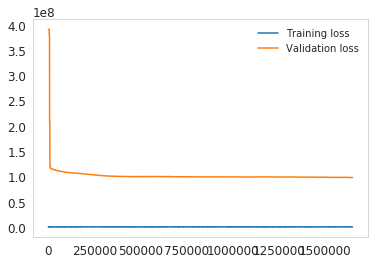

In [0]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [0]:
# house model check point
torch.save(house_model.state_dict(), 'house_model.ckpt')


In [0]:
from sklearn.datasets import fetch_openml
data = fetch_openml (data_id=531, return_X_y=False)


In [0]:
print(data.DESCR)
print(data.feature_names)

**Author**:   
**Source**: Unknown - Date unknown  
**Please cite**:   

The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic
prices and the demand for clean air', J. Environ. Economics & Management,
vol.5, 81-102, 1978.   Used in Belsley, Kuh & Welsch, 'Regression diagnostics
...', Wiley, 1980.   N.B. Various transformations are used in the table on
pages 244-261 of the latter.
Variables in order:
CRIM     per capita crime rate by town
ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
INDUS    proportion of non-retail business acres per town
CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
NOX      nitric oxides concentration (parts per 10 million)
RM       average number of rooms per dwelling
AGE      proportion of owner-occupied units built prior to 1940
DIS      weighted distances to five Boston employment centres
RAD      index of accessibility to radial highways
TAX      full-value property-tax rate per $10

In [0]:
data_boston = pd.DataFrame(data.data, columns=data.feature_names)
data_boston['MEDV'] = data.target


In [0]:
data_boston.head()

CRIM    ZN  INDUS  CHAS    NOX  ...    TAX  PTRATIO       B  LSTAT  MEDV
0  0.00632  18.0   2.31   0.0  0.538  ...  296.0     15.3  396.90   4.98  24.0
1  0.02731   0.0   7.07   0.0  0.469  ...  242.0     17.8  396.90   9.14  21.6
2  0.02729   0.0   7.07   0.0  0.469  ...  242.0     17.8  392.83   4.03  34.7
3  0.03237   0.0   2.18   0.0  0.458  ...  222.0     18.7  394.63   2.94  33.4
4  0.06905   0.0   2.18   0.0  0.458  ...  222.0     18.7  396.90   5.33  36.2

[5 rows x 14 columns]

In [0]:
X = data_boston.iloc[:,0:13]
y = data_boston['MEDV']

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(404, 13) (102, 13) (404,) (102,)
